In [80]:
pip install dtreeviz

In [81]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
cd /content/drive/MyDrive/TFG-AnalisisResultados/

/content/drive/MyDrive/TFG-AnalisisResultados


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np


def load_adnimerge_data():
    adnimerge = pd.read_parquet('./data/reduced_baseline_adnimerge_df.parquet', 'pyarrow')
    adnimerge.dropna(inplace=True)
    adnimerge['DX_bl'] = adnimerge['DX_bl'].astype('string')
    adnimerge_sub = adnimerge[adnimerge['DX_bl'].isin(['LMCI', 'EMCI'])] #binary problem
    adnimerge_sub = adnimerge_sub[['RID', 'DX_bl']]
    return adnimerge_sub


def load_lowdim_data(seed):
    adnimerge_sub = load_adnimerge_data()

    roi_aparc = pd.read_parquet('./data/baseline_roi_aparc_df.parquet')
    roi_aparc.drop(columns= ['lMedial_wall', 'rMedial_wall'], inplace=True)
    roi_aparc['RID'] = roi_aparc['RID'].astype(int)
    roi_aparc.drop(columns=['subject', 'session_number'], inplace=True)
    data = adnimerge_sub.merge(roi_aparc, on='RID', how='inner')

    y_classification = data['DX_bl']
    X = data.drop(columns=['RID', 'DX_bl'])

    X = X.astype('float32')
    y_clas_enc = LabelEncoder()
    y_classification = y_clas_enc.fit_transform(y_classification)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_classification, test_size=0.2, random_state=seed
        )

    class_names = y_clas_enc.classes_  # array like ['class0', 'class1']

    return X_train, X_test, y_train, y_test, class_names


def load_lowdim_neuro_data(seed):
    adnimerge_sub = load_adnimerge_data()

    roi = pd.read_parquet('./data/baseline_roi_neuromorph_df.parquet')
    roi['RID'] = roi['RID'].astype(int)
    roi.drop(columns=['subject', 'session_number'], inplace=True)
    data = adnimerge_sub.merge(roi, on='RID', how='inner')

    y_classification = data['DX_bl']
    X = data.drop(columns=['RID', 'DX_bl'])

    X = X.astype('float32')
    y_clas_enc = LabelEncoder()
    y_classification = y_clas_enc.fit_transform(y_classification)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_classification, test_size=0.2, random_state=seed
        )

    class_names = y_clas_enc.classes_  # array like ['class0', 'class1']


    return X_train, X_test, y_train, y_test, class_names




def load_highdim_data(seed):
    adnimerge_sub = load_adnimerge_data()

    hd_data = pd.read_parquet('./data/baseline_hd_df.parquet')
    hd_data.drop(columns=['ses'], inplace=True)
    hd_data['RID'] = hd_data['RID'].astype(int)
    data = adnimerge_sub.merge(hd_data, on='RID', how='inner')

    y_classification = data['DX_bl']

    # Convert the 'img' column into a 2D NumPy array
    feature_matrix = np.stack(data['img'].values)
    X_expanded = pd.DataFrame(feature_matrix, columns=[f'feature_{i}' for i in range(feature_matrix.shape[1])])

    X = X_expanded.astype('float32')
    y_clas_enc = LabelEncoder()
    y_classification = y_clas_enc.fit_transform(y_classification)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_classification, test_size=0.2, random_state=seed
    )
    class_names = y_clas_enc.classes_  # array like ['class0', 'class1']

    return X_train, X_test, y_train, y_test, class_names



In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def evaluate_rf(X_train, X_test, y_train, y_test, x, seed):
  n_estimators = int(x[0])
  max_depth = int(x[1]) if x[1] > 0 else None
  min_samples_split = int(x[2])
  min_samples_leaf = int(x[3])

  # Train Random Forest
  model = RandomForestClassifier(
      n_estimators=n_estimators,
      max_depth=max_depth,
      min_samples_split=min_samples_split,
      min_samples_leaf=min_samples_leaf,
      random_state=seed
  )
  model.fit(X_train, y_train)

  feature_importances = model.feature_importances_

  # Predict on test data
  y_pred = model.predict(X_test)

  # Calculate test accuracy
  test_accuracy = accuracy_score(y_test, y_pred)

  # Store agreement scores
  agreements = []
  for tree in model.estimators_:
      tree_preds = tree.predict(X_test)
      agreement = np.mean(tree_preds == y_pred)
      agreements.append(agreement)

  # Find the most relevant tree (highest agreement)
  best_tree_index = np.argmax(agreements)
  most_relevant_tree = model.estimators_[best_tree_index]

  return test_accuracy, feature_importances, most_relevant_tree


In [86]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
import graphviz

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np


def visualize_tree(model, feature_names=None, class_names=None, save_path = None):
    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    graph.format = "png"

    graph.render(save_path)  # Saves as tree.pdf/tree.png depending on format
    graph.view()          # Opens the tree visualization



In [87]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importances(importances, feature_names, top_n=None):
    importances = np.array(importances)
    feature_names = np.array(feature_names)

    # Optional: select only top N important features
    if top_n is not None:
        indices = np.argsort(importances)[-top_n:][::-1]
    else:
        indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), feature_names[indices])
    plt.xlabel('Feature Importance')
    plt.title('Random Forest Feature Importances')
    plt.gca().invert_yaxis()  # Highest importance at top
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()



#LD

Features are: ['lUnknown', 'rUnknown', 'lG_and_S_frontomargin', 'rG_and_S_frontomargin', 'lG_and_S_occipital_inf', 'rG_and_S_occipital_inf', 'lG_and_S_paracentral', 'rG_and_S_paracentral', 'lG_and_S_subcentral', 'rG_and_S_subcentral', 'lG_and_S_transv_frontopol', 'rG_and_S_transv_frontopol', 'lG_and_S_cingul-Ant', 'rG_and_S_cingul-Ant', 'lG_and_S_cingul-Mid-Ant', 'rG_and_S_cingul-Mid-Ant', 'lG_and_S_cingul-Mid-Post', 'rG_and_S_cingul-Mid-Post', 'lG_cingul-Post-dorsal', 'rG_cingul-Post-dorsal', 'lG_cingul-Post-ventral', 'rG_cingul-Post-ventral', 'lG_cuneus', 'rG_cuneus', 'lG_front_inf-Opercular', 'rG_front_inf-Opercular', 'lG_front_inf-Orbital', 'rG_front_inf-Orbital', 'lG_front_inf-Triangul', 'rG_front_inf-Triangul', 'lG_front_middle', 'rG_front_middle', 'lG_front_sup', 'rG_front_sup', 'lG_Ins_lg_and_S_cent_ins', 'rG_Ins_lg_and_S_cent_ins', 'lG_insular_short', 'rG_insular_short', 'lG_occipital_middle', 'rG_occipital_middle', 'lG_occipital_sup', 'rG_occipital_sup', 'lG_oc-temp_lat-fusif

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: U

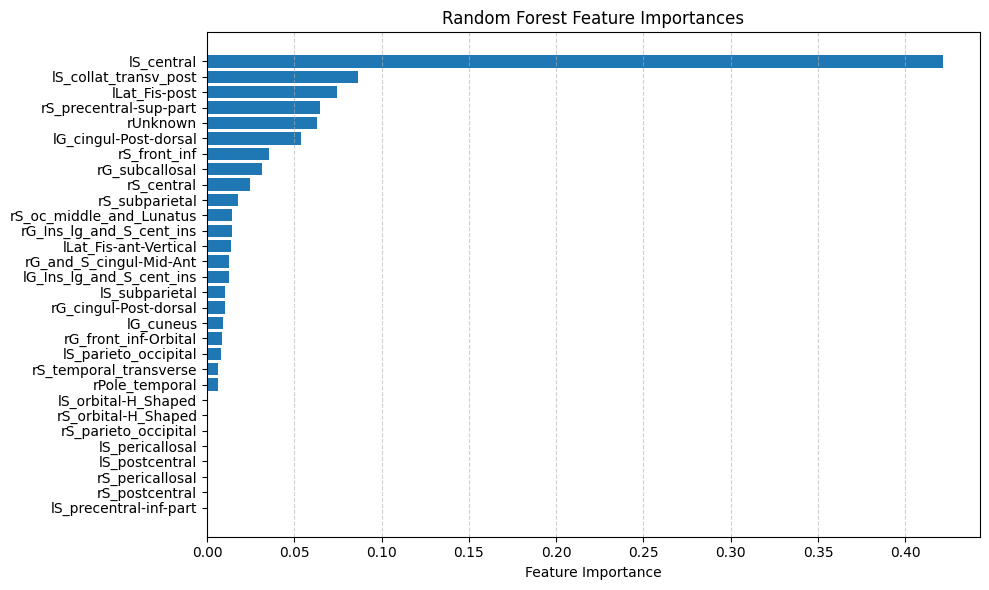

The objective values are [0.7238409284813149, -12.0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: U

Test Accuracy: 0.7209302325581395
Feature Importances: [0.01067434, 0.02366592, 0.00679144, 0.00824457, 0.00257693, 0.00570443,
 0.00910301, 0.00893771, 0.00485192, 0.00349227, 0.00552396, 0.00570113,
 0.00449887, 0.00498545, 0.00492354, 0.0043027 , 0.00944999, 0.01318236,
 0.00993545, 0.01501877, 0.0061229 , 0.00437161, 0.0125501 , 0.0139781 ,
 0.00206548, 0.00337797, 0.00374288, 0.00544573, 0.00254958, 0.00382007,
 0.00264324, 0.00507397, 0.00437829, 0.0051149 , 0.00258604, 0.00466356,
 0.00358089, 0.00555868, 0.0034011 , 0.00393973, 0.00440671, 0.00341459,
 0.00625898, 0.00453492, 0.00653305, 0.00771645, 0.00682879, 0.00565508,
 0.00724216, 0.00693737, 0.00509291, 0.00567541, 0.00460214, 0.00350144,
 0.00581191, 0.00426927, 0.00517087, 0.0034736 , 0.02674258, 0.0061994 ,
 0.00553058, 0.00609108, 0.01246241, 0.00735413, 0.00350471, 0.01134995,
 0.00495038, 0.00420189, 0.00558889, 0.00866208, 0.00462915, 0.00461435,
 0.00679415, 0.00791093, 0.00624767, 0.00510724, 0.01530959, 0.006189

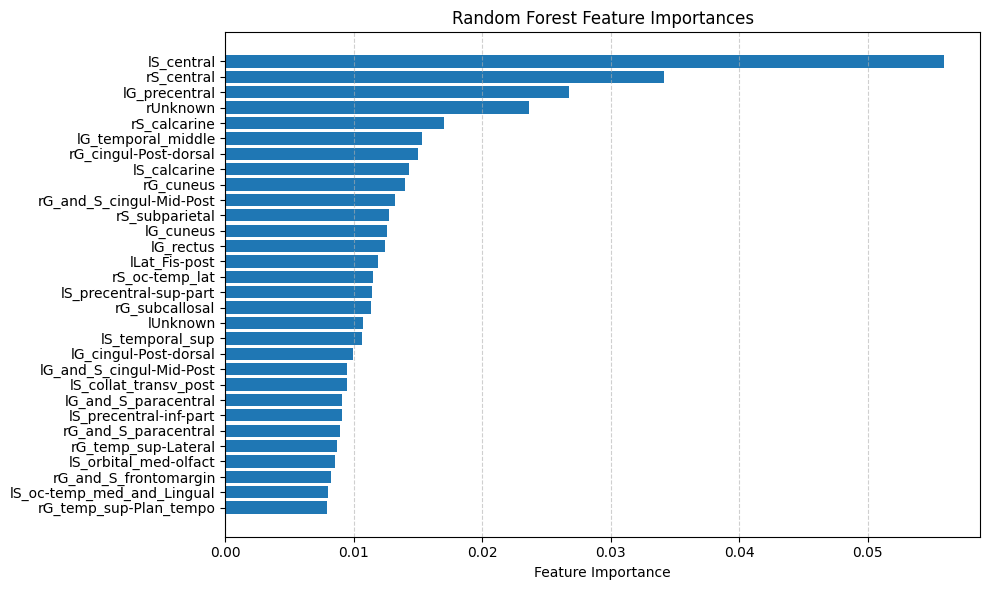

In [88]:

# {'pareto_objective': [0.6987441809073235, -2.0], 'candidates': [[10.0, 2.0, 13.865353079633742, 1.0]]}
pareto_values = [{'pareto_objective': [0.6987441809073235, -2.0],
  'candidates': [[10.0, 2.0, 13.865353079633742, 1.0]]},
 {'pareto_objective': [0.7238409284813149, -12.0],
  'candidates': [[115.65063519403338,
    12.61224259622395,
    11.742437701672316,
    3.2378123868256807]]}]

seed = 4
X_train, X_test, y_train, y_test, class_names = load_lowdim_data(seed)
features = X_train.columns.to_list()

print(f"Features are: {features}")

for i, pareto_dict in enumerate(pareto_values):
  x = pareto_dict['candidates'][0]
  print(f"The objective values are {pareto_dict['pareto_objective']}")

  test_accuracy, feature_importances, model = evaluate_rf(X_train, X_test, y_train, y_test, x, seed)
  pareto_values[i]['test_accuracy'] = test_accuracy

  print(f"Test Accuracy: {test_accuracy}")
  print(f"Feature Importances: {np.array2string(feature_importances, separator=', ')}")
  visualize_tree(model, features, class_names, f'LD_tree_pareto{i}')
  plot_feature_importances(feature_importances, features, top_n = 30)


In [89]:
# Expand 'candidates' into separate columns
pareto_df = pd.DataFrame(pareto_values)

# Flatten one level of nested lists inside 'candidates'
candidates_flat = [c[0] if isinstance(c, list) and len(c) == 1 else c for c in pareto_df['candidates']]

candidates_df = pd.DataFrame(candidates_flat, columns=[
    'N of Estimators',
    'Max Depth',
    'Min samples split',
    'Min samples leaf'
])

candidates_df.drop(columns = ['Max Depth'], inplace=True)
candidates_df = candidates_df.astype(int)

# Split pareto_objective into two columns
pareto_split = pd.DataFrame(pareto_df['pareto_objective'].tolist(), columns=['Pareto Accuracy', 'Pareto Max Depth'])

# Combine all together
final_df = pd.concat([pareto_split, candidates_df, pareto_df['test_accuracy']], axis=1)

# Rename test accuracy
final_df = final_df.rename(columns={'test_accuracy': 'Test Accuracy'})

# Print LaTeX table
print(final_df.to_latex(index=False, float_format="%.4f".__mod__))

\begin{tabular}{rrrrrr}
\toprule
Pareto Accuracy & Pareto Max Depth & N of Estimators & Min samples split & Min samples leaf & Test Accuracy \\
\midrule
0.6987 & -2.0000 & 10 & 13 & 1 & 0.6605 \\
0.7238 & -12.0000 & 115 & 11 & 3 & 0.7209 \\
\bottomrule
\end{tabular}



#LD NEURO

Features are: ['3rd Ventricle', '4th Ventricle', 'Right Accumbens Area', 'Left Accumbens Area', 'Right Amygdala', 'Left Amygdala', 'Brain Stem', 'Right Caudate', 'Left Caudate', 'Right Cerebellum Exterior', 'Left Cerebellum Exterior', 'Right Cerebellum White Matter', 'Left Cerebellum White Matter', 'Right Cerebral White Matter', 'Left Cerebral White Matter', 'CSF', 'Right Hippocampus', 'Left Hippocampus', 'Right Inf Lat Vent', 'Left Inf Lat Vent', 'Right Lateral Ventricle', 'Left Lateral Ventricle', 'Right Pallidum', 'Left Pallidum', 'Right Putamen', 'Left Putamen', 'Right Thalamus Proper', 'Left Thalamus Proper', 'Right Ventral DC', 'Left Ventral DC', 'Right vessel', 'Left vessel', 'Optic Chiasm', 'Cerebellar Vermal Lobules I-V', 'Cerebellar Vermal Lobules VI-VII', 'Cerebellar Vermal Lobules VIII-X', 'Left Basal Forebrain', 'Right Basal Forebrain', 'Right ACgG anterior cingulate gyrus', 'Left ACgG anterior cingulate gyrus', 'Right AIns anterior insula', 'Left AIns anterior insula', 'R

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: U

Test Accuracy: 0.641860465116279
Feature Importances: [0.01470425, 0.01075688, 0.00688695, 0.00793565, 0.01083118, 0.00815118,
 0.00554829, 0.00642223, 0.00594751, 0.00546769, 0.00641917, 0.00488386,
 0.00531816, 0.01073175, 0.0109616 , 0.02246904, 0.0199011 , 0.02130842,
 0.01970668, 0.01972509, 0.01055648, 0.01184766, 0.00812857, 0.01772419,
 0.00691317, 0.01276609, 0.00864044, 0.00495266, 0.00469656, 0.00560889,
 0.        , 0.        , 0.0063775 , 0.00605204, 0.00544383, 0.01132476,
 0.00533095, 0.00826716, 0.00644   , 0.00538634, 0.0039775 , 0.00404231,
 0.00761861, 0.00346829, 0.00372079, 0.00511736, 0.00834957, 0.01232037,
 0.00308629, 0.00403074, 0.00885303, 0.00761867, 0.01722206, 0.01169176,
 0.0048333 , 0.00942737, 0.00567424, 0.00520014, 0.00559396, 0.00391118,
 0.00438198, 0.00691724, 0.00529701, 0.00557487, 0.00539057, 0.00739783,
 0.00853455, 0.00653115, 0.00281745, 0.00476181, 0.00694505, 0.00411095,
 0.00535607, 0.00562293, 0.00426269, 0.00488621, 0.00577003, 0.0048292

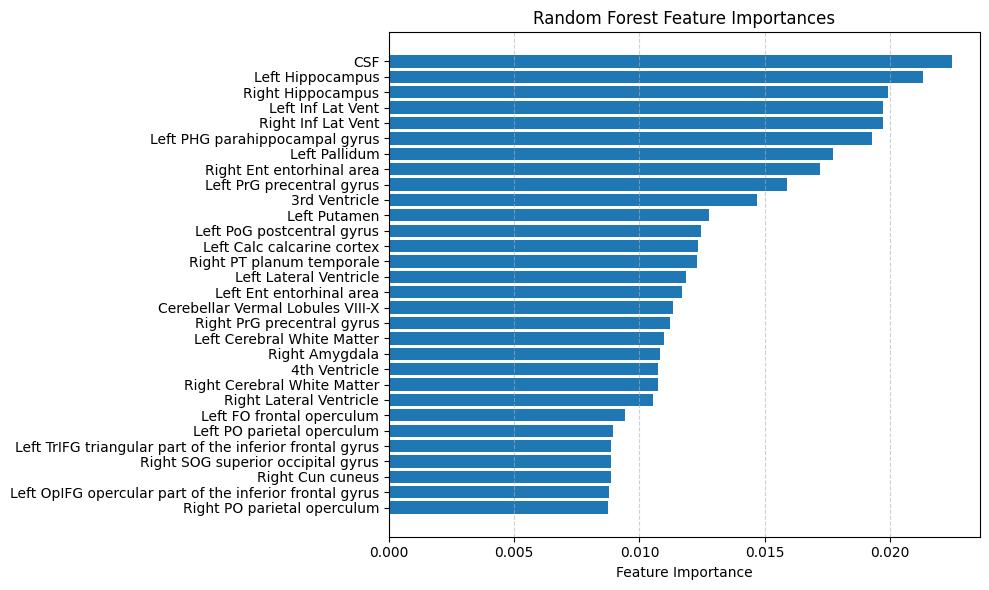

The objective values are [0.6571775279908842, -2.0]
Test Accuracy: 0.6139534883720931
Feature Importances: [0.        , 0.04229466, 0.        , 0.        , 0.        , 0.        ,
 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ,
 0.        , 0.        , 0.        , 0.03679907, 0.08542149, 0.07145414,
 0.06422925, 0.        , 0.        , 0.03096371, 0.        , 0.02414095,
 0.        , 0.        , 0.03140437, 0.        , 0.        , 0.        ,
 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ,
 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ,
 0.        , 0.        , 0.        , 0.        , 0.        , 0.15095147,
 0.        , 0.        , 0.        , 0.        , 0.        , 0.05906614,
 0.        , 0.1055548 , 0.        , 0.        , 0.        , 0.        ,
 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ,
 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ,
 0.        , 0.  

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: U

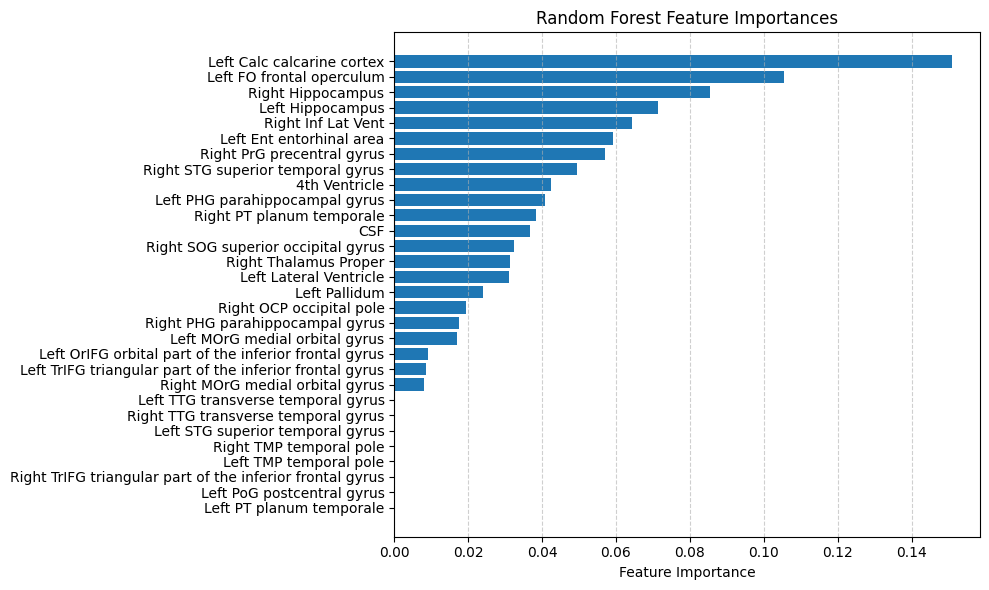

In [90]:

# {'pareto_objective': [0.6987441809073235, -2.0], 'candidates': [[10.0, 2.0, 13.865353079633742, 1.0]]}
pareto_values = [{'pareto_objective': [0.709822065771705, -11.0],
  'candidates': [[191.8326549861824,
    11.08047477503297,
    11.862066855754374,
    1.0]]},
 {'pareto_objective': [0.6571775279908842, -2.0],
  'candidates': [[10.0, 2.0, 15.0, 5.557364390516457]]}]

seed = 2

X_train, X_test, y_train, y_test, class_names = load_lowdim_neuro_data(seed)
features = X_train.columns.to_list()

print(f"Features are: {features}")


for i, pareto_dict in enumerate(pareto_values):
  x = pareto_dict['candidates'][0]
  print(f"The objective values are {pareto_dict['pareto_objective']}")

  test_accuracy, feature_importances, model = evaluate_rf(X_train, X_test, y_train, y_test, x, seed)
  pareto_values[i]['test_accuracy'] = test_accuracy

  print(f"Test Accuracy: {test_accuracy}")
  print(f"Feature Importances: {np.array2string(feature_importances, separator=', ')}")
  visualize_tree(model, features, class_names, f'LD_NEURO_tree_pareto{i}')
  plot_feature_importances(feature_importances, features, top_n = 30)



In [91]:
# Expand 'candidates' into separate columns
pareto_df = pd.DataFrame(pareto_values)

# Flatten one level of nested lists inside 'candidates'
candidates_flat = [c[0] if isinstance(c, list) and len(c) == 1 else c for c in pareto_df['candidates']]

candidates_df = pd.DataFrame(candidates_flat, columns=[
    'N of Estimators',
    'Max Depth',
    'Min samples split',
    'Min samples leaf'
])

candidates_df.drop(columns = ['Max Depth'], inplace=True)
candidates_df = candidates_df.astype(int)

# Split pareto_objective into two columns
pareto_split = pd.DataFrame(pareto_df['pareto_objective'].tolist(), columns=['Pareto Accuracy', 'Pareto Max Depth'])

# Combine all together
final_df = pd.concat([pareto_split, candidates_df, pareto_df['test_accuracy']], axis=1)

# Rename test accuracy
final_df = final_df.rename(columns={'test_accuracy': 'Test Accuracy'})

# Print LaTeX table
print(final_df.to_latex(index=False, float_format="%.4f".__mod__))

\begin{tabular}{rrrrrr}
\toprule
Pareto Accuracy & Pareto Max Depth & N of Estimators & Min samples split & Min samples leaf & Test Accuracy \\
\midrule
0.7098 & -11.0000 & 191 & 11 & 1 & 0.6419 \\
0.6572 & -2.0000 & 10 & 15 & 5 & 0.6140 \\
\bottomrule
\end{tabular}



# HD

Features are: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64', 'feature_65', 'feature_66', 'feature_67', 'feature_68', 'feature_69', 'feature_70', '

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: U

Test Accuracy: 0.7345971563981043
Feature Importances: [0. 0. 0. ... 0. 0. 0.]


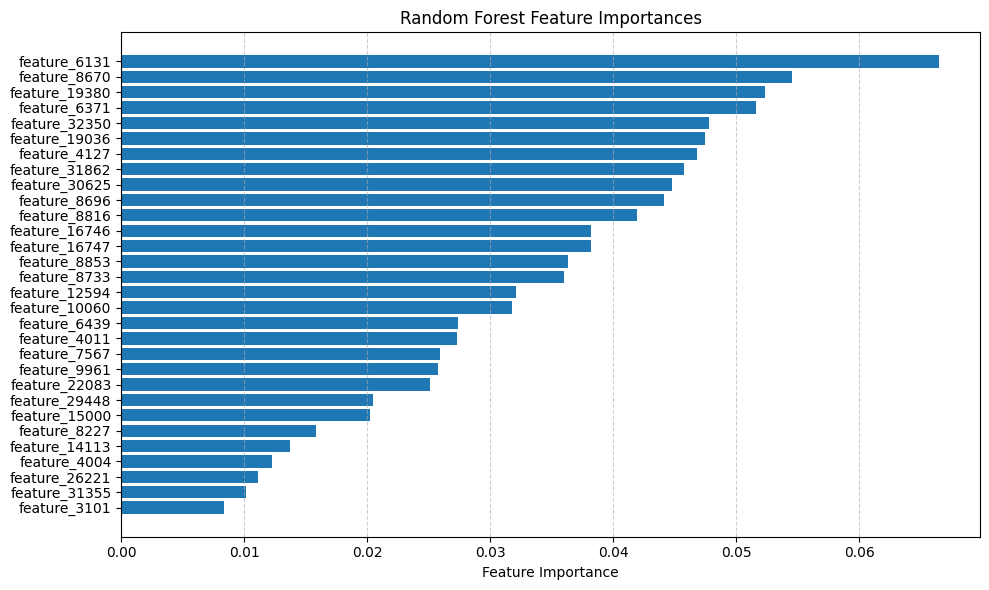

The objective values are [0.6960183789759306, -2.0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: U

Test Accuracy: 0.7345971563981043
Feature Importances: [0. 0. 0. ... 0. 0. 0.]


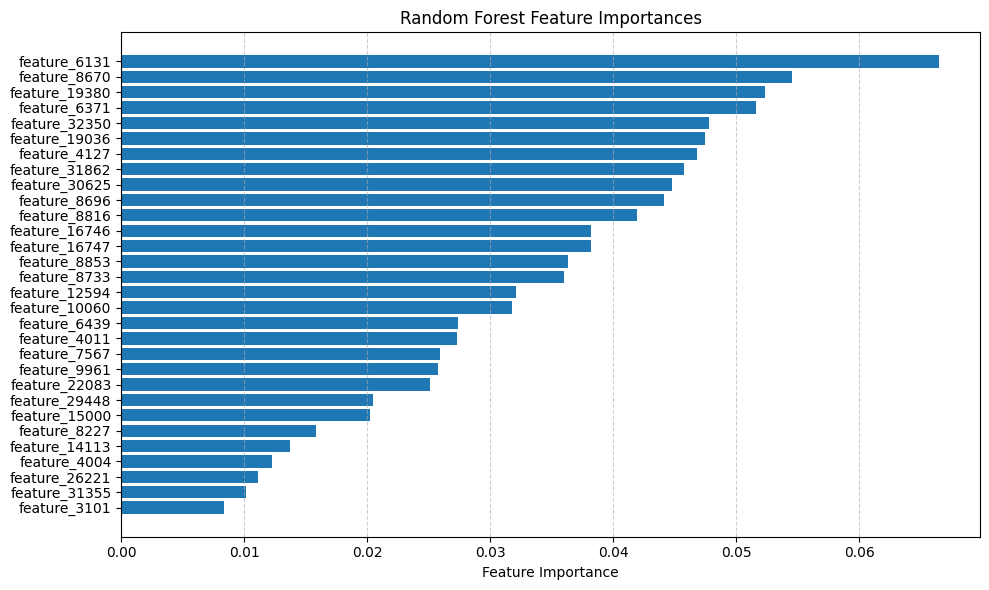

The objective values are [0.7133803250468029, -6.0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: U

Test Accuracy: 0.7298578199052133
Feature Importances: [0.         0.00010983 0.         ... 0.         0.00013889 0.        ]


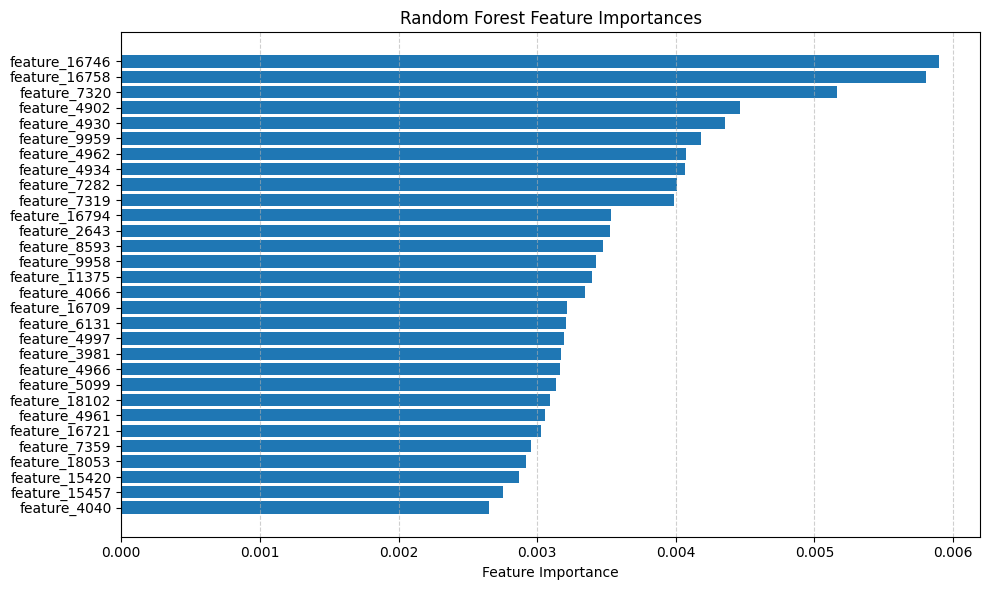

The objective values are [0.7235663155630252, -21.0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: U

Test Accuracy: 0.7535545023696683
Feature Importances: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 1.83588686e-04 3.17365774e-05]


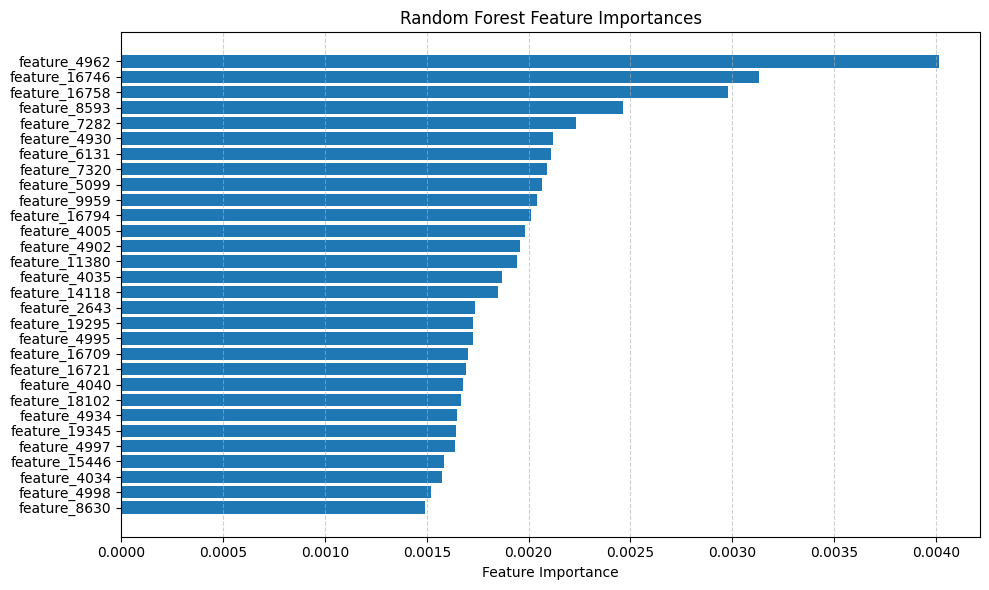

The objective values are [0.7347050248907269, -24.0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: U

Test Accuracy: 0.7345971563981043
Feature Importances: [0.         0.         0.         ... 0.         0.00027857 0.        ]


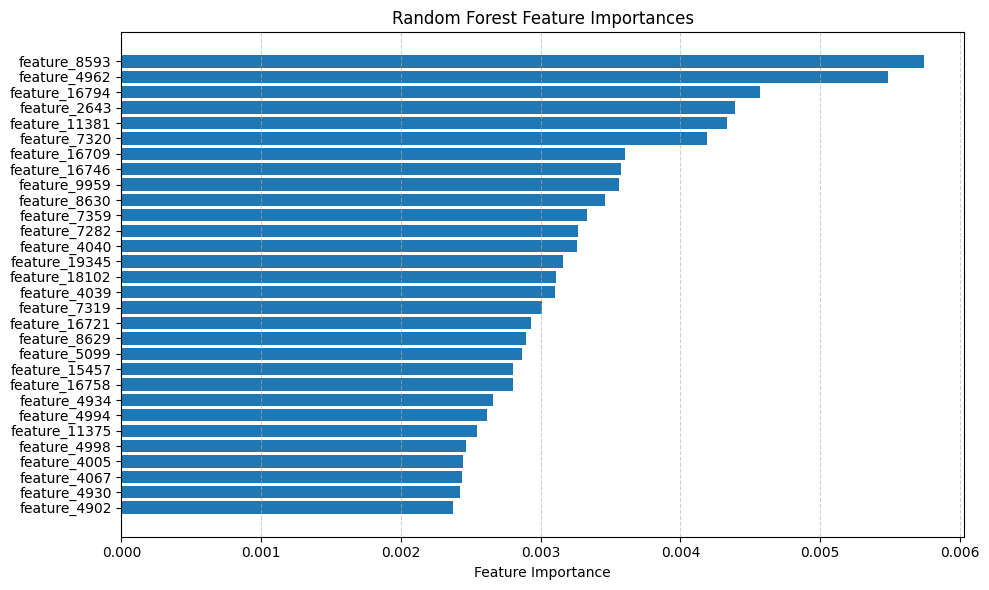

The objective values are [0.7174101546951157, -18.0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: U

Test Accuracy: 0.7345971563981043
Feature Importances: [0.         0.         0.         ... 0.00013361 0.00014571 0.        ]


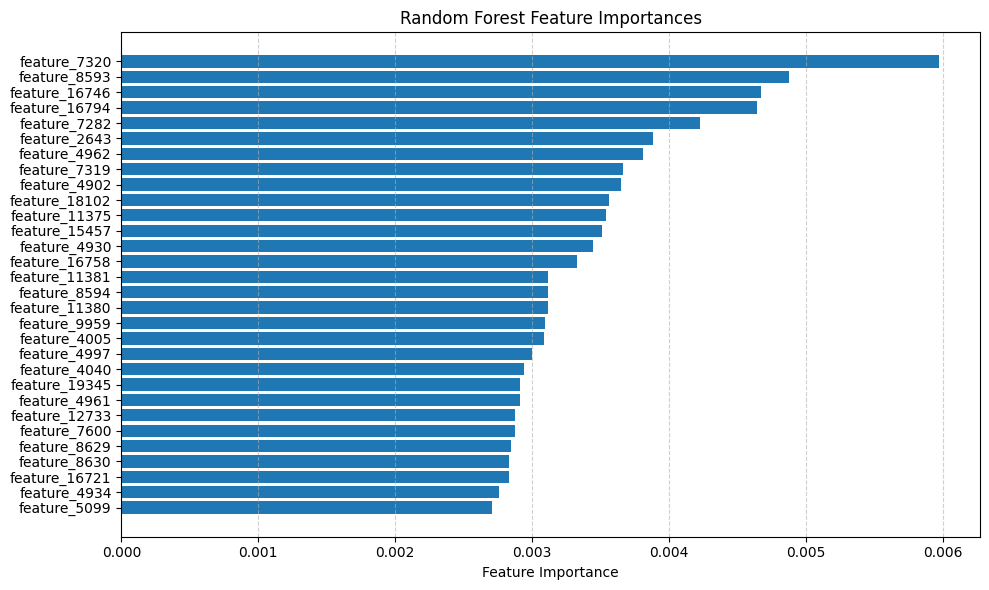

In [96]:

# {'pareto_objective': [0.6987441809073235, -2.0], 'candidates': [[10.0, 2.0, 13.865353079633742, 1.0]]}
pareto_values = [
 {'pareto_objective': [0.6960183789759306, -2.0],
  'candidates': [[10.0, 2.0, 15.0, 1.0]]},
   {'pareto_objective': [0.6960183789759306, -2.0],
    'candidates': [[10.0, 2.0, 15.0, 2.8519642066382085]]},
 {'pareto_objective': [0.7133803250468029, -6.0],
  'candidates': [[300.0, 6.3303418936037374, 2.0, 15.0]]},
 {'pareto_objective': [0.7235663155630252, -21.0],
  'candidates': [[300.0, 21.87401197716849, 2.0, 1.0]]},
 {'pareto_objective': [0.7347050248907269, -24.0],
  'candidates': [[217.34134177611915,
    24.45830291062812,
    9.805706036064644,
    10.328414455640301]]},
 {'pareto_objective': [0.7174101546951157, -18.0],
  'candidates': [[242.57565479009824,
    18.67477759699309,
    15.0,
    13.806194953951449]]}]

seed = 0
X_train, X_test, y_train, y_test, class_names = load_highdim_data(seed)
features = X_train.columns.to_list()

print(f"Features are: {features}")


for i, pareto_dict in enumerate(pareto_values):
  x = pareto_dict['candidates'][0]
  print(f"The objective values are {pareto_dict['pareto_objective']}")

  test_accuracy, feature_importances, model = evaluate_rf(X_train, X_test, y_train, y_test, x, seed)
  pareto_values[i]['test_accuracy'] = test_accuracy

  print(f"Test Accuracy: {test_accuracy}")
  print(f"Feature Importances: {feature_importances}")

  with open(f"feature_importances{i}.txt", "w") as f:
      f.write(", ".join(map(str, feature_importances)))

  visualize_tree(model, features, class_names, f'HD_tree_pareto{i}')
  plot_feature_importances(feature_importances, features, top_n = 30)

In [93]:
# Expand 'candidates' into separate columns
pareto_df = pd.DataFrame(pareto_values)

# Flatten one level of nested lists inside 'candidates'
candidates_flat = [c[0] if isinstance(c, list) and len(c) == 1 else c for c in pareto_df['candidates']]

candidates_df = pd.DataFrame(candidates_flat, columns=[
    'N of Estimators',
    'Max Depth',
    'Min samples split',
    'Min samples leaf'
])

candidates_df.drop(columns = ['Max Depth'], inplace=True)
candidates_df = candidates_df.astype(int)

# Split pareto_objective into two columns
pareto_split = pd.DataFrame(pareto_df['pareto_objective'].tolist(), columns=['Pareto Accuracy', 'Pareto Max Depth'])

# Combine all together
final_df = pd.concat([pareto_split, candidates_df, pareto_df['test_accuracy']], axis=1)

# Rename test accuracy
final_df = final_df.rename(columns={'test_accuracy': 'Test Accuracy'})

# Print LaTeX table
print(final_df.to_latex(index=False, float_format="%.4f".__mod__))

\begin{tabular}{rrrrrr}
\toprule
Pareto Accuracy & Pareto Max Depth & N of Estimators & Min samples split & Min samples leaf & Test Accuracy \\
\midrule
0.6960 & -2.0000 & 10 & 15 & 1 & 0.7346 \\
0.6960 & -2.0000 & 10 & 15 & 2 & 0.7346 \\
0.7134 & -6.0000 & 300 & 2 & 15 & 0.7299 \\
0.7236 & -21.0000 & 300 & 2 & 1 & 0.7536 \\
0.7347 & -24.0000 & 217 & 9 & 10 & 0.7346 \\
0.7174 & -18.0000 & 242 & 15 & 13 & 0.7346 \\
\bottomrule
\end{tabular}

